### matrix sketching algorithm 
[colab link](https://colab.research.google.com/drive/18KQMCVJbpzbvKVe-xg0SmvmQqxNsUCNO?usp=sharing)

install requirments, upload the file requirmnets.txt

In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 4.3 MB/s 
     |████████████████████████████████| 4.1 MB 42.6 MB/s 
     |████████████████████████████████| 10.1 MB 43.1 MB/s 
     |████████████████████████████████| 295 kB 59.8 MB/s 
     |████████████████████████████████| 503 kB 74.4 MB/s 
     |████████████████████████████████| 10.7 MB 41.2 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: scs
    Found existing installation: scs 3.2.2
    Uninstalling scs-3.2.2:
      Successfully uninstalled scs-3.2.2
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.6
    Uninstalling pytz-2022.6:
      Successfully uninstalled pytz-2022.6
  Attempting uninstall: osqp
    Found existing installation: osqp 0.6.2.post0
    Uninstalling osqp-0.6.2.post0:
      Su

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io
import numpy as np
import numpy as np
from scipy.sparse import hstack
import os
import scipy.io as spio
import cvxpy as cp
import numpy as np
import mosek
import time
import json
import os
from natsort import natsorted
import numpy as np
from scipy.sparse import csr_matrix
import h5py
import matplotlib.pyplot as plt

import license file for mosek optimizer

In [ ]:
import os

os.environ['MOSEKLM_LICENSE_FILE']="/content/"

In [ ]:
def createIMRTPlan(metaData, beamIndices=None):

    myPlan = metaData.copy()
    del myPlan['beams']
    beamReq = dict()
    inds = []
    for i in range(len(beamIndices)):
        if beamIndices[i] in metaData['beams']['Index']:
                    ind = np.where(np.array(metaData['beams']['Index']) == beamIndices[i])
                    ind = ind[0][0]
                    inds.append(ind)
                    for key in metaData['beams']:
                        beamReq.setdefault(key, []).append(metaData['beams'][key][ind])
    myPlan['beams'] = beamReq
    if len(inds) < len(beamIndices):
        print('some indices are not available')
    myPlan = loadData(myPlan, myPlan['patientFolderPath'])
    myPlan = infMatrixConcatenate(myPlan)

    return myPlan

def getVoxels(myPlan, org):
    for i in range(len(myPlan['structures']['Names'])):
        if myPlan['structures']['Names'][i] == org:
            vox = myPlan['structures']['optimizationVoxIndices'][i]

    return vox


def infMatrixConcatenate(myPlan):
    if 'influenceMatrixSparse' in myPlan['beams']:
        # myPlan['infMatrixSparse'] = []
        for i in range(np.size(myPlan['beams']['Index'])):
            map_i = myPlan['beams']['beamEyeViewBeamletMap'][i]
            if i == 0:
                myPlan['infMatrixSparse'] = myPlan['beams']['influenceMatrixSparse'][i]
            else:
                myPlan['infMatrixSparse'] = hstack([myPlan['infMatrixSparse'], myPlan['beams']['influenceMatrixSparse'][i]], format='csr')
            logicalMap = map_i > 0
            a = np.sort(map_i.flatten())
            a = np.unique(a)
            secondMin = a[1]
            # secondMin = a[1]
            if i != 0:
                standardMap = np.int32(map_i) - secondMin * np.int32(logicalMap) + np.int32(logicalMap)
                map = standardMap + np.amax(myPlan['beams']['beamEyeViewBeamletMap'][i - 1]) * np.int32(logicalMap)
            else:
                map = np.int32(map_i) - secondMin * np.int32(logicalMap) + np.int32(logicalMap)
            myPlan['beams']['beamEyeViewBeamletMap'][i] = map
            standInd = np.unique(np.sort(map.flatten()))
            myPlan['beams'].setdefault('firstBeamlet', []).append(standInd[1])
            myPlan['beams'].setdefault('endBeamlet', []).append(np.amax(map))
            print(standInd[1])
            print(np.amax(map))
        del myPlan['beams']['influenceMatrixSparse']
    if 'influenceMatrixFull' in myPlan['beams']:
        myPlan['infMatrixFull'] = []
        for i in range(np.size(myPlan['beams'])):
            map_i = myPlan['beams']['beamEyeViewBeamletMap'][i]
            if i == 0:
                myPlan['infMatrixFull'] = myPlan['beams']['influenceMatrixFull'][i]
            else:
                myPlan['infMatrixFull'] = hstack([myPlan['infMatrixFull'], myPlan['beams']['influenceMatrixFull'][i]], format='csr')
            logicalMap = map_i > 0
            a = np.sort(map_i.flatten())
            a = np.unique(a)
            secondMin = a[1]
            # secondMin = a[1]
            if i != 0:
                standardMap = np.int32(map_i) - secondMin * np.int32(logicalMap) + np.int32(logicalMap)
                map = standardMap + np.amax(myPlan['beams']['beamEyeViewBeamletMap'][i - 1]) * np.int32(logicalMap)
            else:
                map = np.int32(map_i) - secondMin * np.int32(logicalMap) + np.int32(logicalMap)

            myPlan['beams']['beamEyeViewBeamletMap'][i] = map
            standInd = np.unique(np.sort(map.flatten()))
            myPlan['beams'].setdefault('firstBeamlet', []).append(standInd[1])
            myPlan['beams'].setdefault('endBeamlet', []).append(np.amax(map))
        del myPlan['beams']['influenceMatrixFull']
    return myPlan


def loadData(myData, folderPath):
    # fn = myData.keys()
    for key in myData.copy():
        item = myData[key]
        if type(item) is dict:
            myData[key] = loadData(item, folderPath)
        elif key.endswith('_File') and key != 'influenceMatrixFull_File' and key != 'ctVoxIndices_File':
            success = 1
            for i in range(np.size(myData[key])):
                dataFolder = folderPath
                if myData[key][i].startswith('Beam_') :
                    dataFolder = os.path.join(dataFolder, 'Beams')
                if type(myData[key]) is not list:
                    file_tag = myData[key].split('.h5')
                else:
                    file_tag = myData[key][i].split('.h5')
                filename = os.path.join(dataFolder, file_tag[0] + '.h5')
                with h5py.File(filename, "r") as f:
                    if file_tag[1] in f:
                        if key[0:-5] == 'optimizationVoxIndices':
                            vox = f[file_tag[1]][:].T.ravel()
                            myData.setdefault(key[0:-5], []).append(vox.astype(int))
                        elif key[0:-5] == 'beamEyeViewStructureMask':
                            orgs = f[file_tag[1]].keys()
                            for j in orgs:
                                myData.setdefault(key[0:-5], dict()).setdefault('Organ', []).append(j)
                                myData.setdefault(key[0:-5], dict()).setdefault('Mask', []).append(f[file_tag[1]][j][:].T)
                        else:
                            myData.setdefault(key[0:-5], []).append(f[file_tag[1]][:].T)
                        if key[0:-5] == 'influenceMatrixSparse':
                            infMatrixSparseForBeam = myData[key[0:-5]][i]
                            myData[key[0:-5]][i] = csr_matrix((infMatrixSparseForBeam[:, 2], (infMatrixSparseForBeam[:, 0].astype(int) - 1,
                                         infMatrixSparseForBeam[:, 1].astype(int) - 1)))
                    else:
                        print('Problem reading Data: {}'.format(myData[key][i]))
                        success = 0
            if success:
                del myData[key]

    return myData



import itertools
def listtodict(jsondata):
    '''
    A recursive function which constructs from dictionary from list of dictionary
    '''
    jsondict = {}
    if type(jsondata) is list:
        for i in range(len(jsondata)):
            elem = jsondata[i]
            if type(elem) is list:
                jsondict[i] = listtodict(elem)
            else:
                for key in elem:
                    jsondict.setdefault(key, []).append(elem[key])
    else:
        jsondict = jsondata.copy()
    return jsondict

def loadMetaData(path):
    metaData = dict()

    fname = os.path.join(path, 'StructureSet_MetaData.json')
    # Opening JSON file
    f = open(fname)
    jsondata = json.load(f)
    metaData['structures'] = listtodict(jsondata)


    fname = os.path.join(path, 'MachineParams_MetaData.json')
    # Opening JSON file
    f = open(fname)
    jsondata = json.load(f)
    metaData['machineParams'] = listtodict(jsondata)

    fname = os.path.join(path, 'OptimizationVoxels_MetaData.json')
    # Opening JSON file
    f = open(fname)
    jsondata = json.load(f)
    metaData['optVoxels'] = listtodict(jsondata)


    fname = os.path.join(path, 'CT_MetaData.json')
    if os.path.isfile(fname):
        # Opening JSON file
        f = open(fname)
        jsondata = json.load(f)
        metaData['ct'] = listtodict(jsondata)

    fname = os.path.join(path, 'ClinicalCriteria_MetaData.json')
    # Opening JSON file
    f = open(fname)
    jsondata = json.load(f)
    metaData['clinicalCriteria'] = listtodict(jsondata)

    beamFolder = os.path.join(path, 'Beams')
    beamsJson = [pos_json for pos_json in os.listdir(beamFolder) if pos_json.endswith('.json')]

    beamsJson = natsorted(beamsJson)
    metaData['beams'] = dict()
    for i in range(len(beamsJson)):
        fname = os.path.join(beamFolder, beamsJson[i])
        f = open(fname)
        jsondata = json.load(f)

        for key in jsondata:
            metaData['beams'].setdefault(key, []).append(jsondata[key])
            # dataMeta['beamsMetaData'][key].append(jsondata[key])

    metaData['patientFolderPath'] = path
    return metaData



def getVoxels(myPlan, org):
    for i in range(len(myPlan['structures']['Names'])):
        if myPlan['structures']['Names'][i] == org:
            vox = myPlan['structures']['optimizationVoxIndices'][i]

    return vox


def getSmoothnessMatrix(beamReq):
    sRow = np.zeros((beamReq['endBeamlet'][-1], beamReq['endBeamlet'][-1]), dtype=int)
    sCol= np.zeros((beamReq['endBeamlet'][-1], beamReq['endBeamlet'][-1]), dtype=int)
    for b in range(len(beamReq['Index'])):
        map = beamReq['beamEyeViewBeamletMap'][b]

        rowsNoRepeat = [0]
        for i in range(1, np.size(map, 0)):
            if (map[i,:] != map[rowsNoRepeat[-1], :]).any():
                rowsNoRepeat.append(i)
        colsNoRepeat = [0]
        for j in range(1, np.size(map, 1)):
            if (map[:, j] != map[:, colsNoRepeat[-1]]).any():
                colsNoRepeat.append(j)
        map = map[np.ix_(np.asarray(rowsNoRepeat), np.asarray(colsNoRepeat))]
        for r in range(np.size(map, 0)):
            startCol = 0
            endCol = np.size(map, 1) - 2
            while (map[r, startCol] == 0) and (startCol <= endCol):
                startCol = startCol + 1
            while ((map[r, endCol] == 0) and (startCol <= endCol)):
                endCol = endCol - 1

            for c in range(startCol, endCol+1):
                ind = map[r, c]
                RN = map[r, c + 1]
                if ind * RN > 0:
                    sRow[ind-1, ind-1] = int(1)
                    sRow[ind-1, RN-1] = int(-1)

        for c in range(np.size(map, 1)):
            startRow = 0
            endRow = np.size(map, 0) - 2
            while (map[startRow, c] == 0) and (startRow <= endRow):
                startRow = startRow + 1
            while (map[endRow, c] == 0) and (startRow <= endRow):
                endRow = endRow - 1
            for r in range(startRow, endRow+1):
                ind = map[r, c]
                DN = map[r+1, c]
                if ind * DN > 0:
                    sCol[ind-1, ind-1] = int(1)
                    sCol[ind-1, DN-1] = int(-1)
    return sRow, sCol


def runIMRTOptimization_CVX(myPlan):
    t = time.time()

    print(myPlan)

    infMatrix = myPlan['infMatrixSparse']
    print("infMatrix: ", infMatrix)
    print("====================================================")
    clinicalConstraints = myPlan['clinicalCriteria']['constraints']
    print("clinicalConstraints: ", clinicalConstraints)
    print("====================================================")
    pres = myPlan['clinicalCriteria']['presPerFraction_Gy']
    print("pres: ", pres)
    print("====================================================")
    numFractions = myPlan['clinicalCriteria']['numOfFraction']
    print("numFractions: ", numFractions)
    print("====================================================")
    [X, Y] = getSmoothnessMatrix(myPlan['beams'])
    print("beams: ", myPlan['beams'])
    print("[X, Y]: ", [X, Y])
    print("====================================================")



    # Construct the problem.
    w = cp.Variable(infMatrix.shape[1], pos=True)
    dO = cp.Variable(len(getVoxels(myPlan, 'PTV')), pos=True)
    dU = cp.Variable(len(getVoxels(myPlan, 'PTV')), pos=True)
    # Form objective.
    print('Objective Start')
    obj = []

    ##Step 1 objective

    ##obj.append((1/sum(pars['points'][(getVoxels(myPlan,'PTV'))-1, 3]))*cp.sum_squares(cp.multiply(cp.sqrt(pars['points'][(getVoxels(myPlan,'PTV'))-1, 3]), infMatrix[getVoxels(myPlan,'PTV')-1, :] @ w + wMean*pars['alpha']*pars['delta'][getVoxels(myPlan,'PTV')-1] - pars['presPerFraction'])))
    obj.append(10000*(1/len(getVoxels(myPlan, 'PTV')))*(cp.sum_squares(dO) + 10*cp.sum_squares(dU)))

    ##Smoothing objective function

    obj.append(1000*(0.6*cp.sum_squares(X @ w) + 0.4*cp.sum_squares(Y @ w)))

    print('Objective done')
    print('Constraints Start')
    constraints = []
    # constraints += [wMean == cp.sum(w)/w.shape[0]]
    for i in range(len(clinicalConstraints)):
        if clinicalConstraints[i]['maxHardConstraint_Gy'] is not None:
            org = clinicalConstraints[i]['structNames']
            if org != 'GTV':
                constraints += [infMatrix[getVoxels(myPlan, org)-1, :] @ w <= clinicalConstraints[i]['maxHardConstraint_Gy']/numFractions]
        if clinicalConstraints[i]['meanHardConstraint_Gy'] is not None:
            org = clinicalConstraints[i]['structNames']
            constraints += [(1/len(getVoxels(myPlan, org)))*(cp.sum(infMatrix[getVoxels(myPlan, org)-1, :] @ w)) <= clinicalConstraints[i]['meanHardConstraint_Gy']/numFractions]

    ##Step 1 and 2 constraint
    constraints += [infMatrix[getVoxels(myPlan, 'PTV')-1, :] @ w <= pres + dO]
    constraints += [infMatrix[getVoxels(myPlan, 'PTV')-1, :] @ w >= pres - dU]

    ##Smoothness Constraint
    for b in range(len(myPlan['beams']['Index'])):
          startB = myPlan['beams']['firstBeamlet'][b]
          endB = myPlan['beams']['endBeamlet'][b]
          constraints += [0.6*cp.sum_squares(X[startB-1:endB-1, startB-1:endB-1] @ w[startB-1:endB-1]) + 0.4*cp.sum_squares(Y[startB-1:endB-1, startB-1:endB-1] @ w[startB-1:endB-1]) <= 0.5]

    print('Constraints Done')

    prob = cp.Problem(cp.Minimize(sum(obj)), constraints)
    # Defining the constraints
    print('Problem loaded')
    prob.solve(solver=cp.MOSEK, verbose=True)
    print("optimal value with MOSEK:", prob.value)
    elapsed = time.time() - t
    print('Elapsed time {} seconds'.format(elapsed))
    return w.value
    

In [ ]:
import os


# provide patient name
# patientName = 'Lung_Patient_2'
# patientFolderPath = os.path.join(os.getcwd(), "..", 'TCIA_Data', patientName)
patientFolderPath = "/content/drive/MyDrive/PORT/TCIA_Data/Lung_Patient_2"

# read all the meta data for the required patient
metaData = loadMetaData(patientFolderPath)

## Provide beam Indices after viewing the metaData
beamIndices = [10, 20, 30, 40]

##create IMRT Plan for the input beamIndices 
myPlan = createIMRTPlan(metaData, beamIndices=beamIndices)


1
630
631
1399
1400
2171
2172
2838


In [ ]:
#fluence optimization for the given beams in myPlan
w = runIMRTOptimization_CVX(myPlan)

{'structures': {'Names': ['GTV', 'PTV', 'ESOPHAGUS', 'HEART', 'LUNG_L', 'LUNG_R', 'CORD', 'SKIN', 'RIND11_PTV_0mm_5mm', 'RIND12_PTV_5mm_5mm', 'RIND13_PTV_5mm_20mm', 'RIND14_PTV_20mm_30mm', 'RIND15_PTV_30mm_infmm'], 'Volume_cc': [356.987366, 737.229248, 54.8894768, 1069.187, 1969.53369, 1890.88989, 63.2911873, 1, None, None, None, None, None], 'fracVolInCalBox': [1, 1, 0.6151774, 0.999940753, 0.68999213, 0.669604957, 0.4539379, 1, None, None, None, None, None], 'ctVoxIndices_File': [None, None, None, None, None, None, None, None, None, None, None, None, None], 'optimizationVoxIndices': [array([ 97428,  97429,  97430, ..., 276215, 276326, 276327]), array([ 75675,  75676,  75677, ..., 297669, 297670, 297671]), array([  2786,   2787,   2788, ..., 359528, 359529, 359530]), array([   921,    922,    923, ..., 268204, 268205, 268301]), array([  1556,   1649,   1650, ..., 361683, 361684, 361685]), array([  1035,   1120,   1121, ..., 361434, 361435, 361436]), array([  5806,   5807,   5808, ...,

In [ ]:
w

array([0.36992106, 0.36788833, 0.36520005, ..., 0.34395024, 0.36062155,
       0.37261279])

In [ ]:
def unconstrained_LS(myPlan):
  A = myPlan['infMatrixSparse']
  print("shape: ", A.shape)

  m, n = A.shape

  d = np.zeros(m)
  gtv = getVoxels(myPlan, 'GTV')
  ptv = getVoxels(myPlan, 'PTV')
  d[gtv - 1] = 2
  d[ptv - 1] = 2

  ans = scipy.sparse.linalg.lsqr(A, d)
  return ans

In [ ]:
ans = unconstrained_LS(myPlan)

shape:  (362462, 3916)


In [ ]:
ans

(array([-0.04045452,  0.02148423, -0.03511601, ..., -0.01003671,
         0.01704058, -0.0250344 ]),
 2,
 276,
 229.23214554239746,
 229.23214554239746,
 370.7315068262001,
 1334.4312176700887,
 0.000808520373171812,
 17.889317704939803,
 array([0., 0., 0., ..., 0., 0., 0.]))

In [ ]:
print("norm1: ", ans[2], "norm2: ", ans[4])

norm1:  276 norm2:  229.23214554239746


In [ ]:
from sklearn.linear_model import LinearRegression as LR

A = myPlan['infMatrixSparse']
m, n = A.shape
d = np.zeros(m)
gtv = getVoxels(myPlan, 'GTV')
ptv = getVoxels(myPlan, 'PTV')
d[gtv - 1] = 2
d[ptv - 1] = 2

lr_model = LR().fit(A, d)
res_uncons = lr_model.predict(A) - d
l2_res_org = np.linalg.norm(res_uncons, 2)
print('L2 norm: ', l2_res_org)

L2 norm:  227.84975261282548


In [ ]:
myPlan

{'structures': {'Names': ['GTV',
   'PTV',
   'ESOPHAGUS',
   'HEART',
   'LUNG_L',
   'LUNG_R',
   'CORD',
   'SKIN',
   'RIND11_PTV_0mm_5mm',
   'RIND12_PTV_5mm_5mm',
   'RIND13_PTV_5mm_20mm',
   'RIND14_PTV_20mm_30mm',
   'RIND15_PTV_30mm_infmm'],
  'Volume_cc': [356.987366,
   737.229248,
   54.8894768,
   1069.187,
   1969.53369,
   1890.88989,
   63.2911873,
   1,
   None,
   None,
   None,
   None,
   None],
  'fracVolInCalBox': [1,
   1,
   0.6151774,
   0.999940753,
   0.68999213,
   0.669604957,
   0.4539379,
   1,
   None,
   None,
   None,
   None,
   None],
  'ctVoxIndices_File': [None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None],
  'optimizationVoxIndices': [array([ 97428,  97429,  97430, ..., 276215, 276326, 276327]),
   array([ 75675,  75676,  75677, ..., 297669, 297670, 297671]),
   array([  2786,   2787,   2788, ..., 359528, 359529, 359530]),
   array([   921,    922,    923, ..., 268204, 268205, 268301])

In [ ]:
myPlan['structures']['Names']

['GTV',
 'PTV',
 'ESOPHAGUS',
 'HEART',
 'LUNG_L',
 'LUNG_R',
 'CORD',
 'SKIN',
 'RIND11_PTV_0mm_5mm',
 'RIND12_PTV_5mm_5mm',
 'RIND13_PTV_5mm_20mm',
 'RIND14_PTV_20mm_30mm',
 'RIND15_PTV_30mm_infmm']

In [ ]:
def constrained_LS(myPlan):
  A = myPlan['infMatrixSparse']
  m, n = A.shape
  d = np.zeros(m)
  gtv = getVoxels(myPlan, 'GTV')
  ptv = getVoxels(myPlan, 'PTV')
  d[gtv - 1] = 2
  d[ptv - 1] = 2
  constraints = []
  x = cp.Variable(n, nonneg=True)
  clinicalConstraints = myPlan['clinicalCriteria']['constraints']
  numFractions = myPlan['clinicalCriteria']['numOfFraction']

  for i in range(len(clinicalConstraints)):
    if clinicalConstraints[i]['maxHardConstraint_Gy'] is not None:
      org = clinicalConstraints[i]['structNames']
      if org != 'GTV':
        constraints += [(A@x)[getVoxels(myPlan, org)-1] <= clinicalConstraints[i]['maxHardConstraint_Gy']/numFractions]
    if clinicalConstraints[i]['meanHardConstraint_Gy'] is not None:
      org = clinicalConstraints[i]['structNames']
      constraints += [(1/len(getVoxels(myPlan, org)))*(cp.sum((A@x)[getVoxels(myPlan, org)-1])) <= clinicalConstraints[i]['meanHardConstraint_Gy']/numFractions]

  obj = cp.Minimize(cp.sum_squares(A@x - d))
  prob = cp.Problem(obj, constraints)
  prob.solve(solver=cp.MOSEK, verbose=True)
  return x.value, prob.value


In [ ]:
opt_value, opt_cost = constrained_LS(myPlan)

In [ ]:
np.linalg.norm(A@opt_value - d)

178.77408479493047

### 1. Normal matrix sketching

In [ ]:
l2_res = []

A = myPlan['infMatrixSparse']
m, n = A.shape
d = np.zeros(m)
gtv = getVoxels(myPlan, 'GTV')
ptv = getVoxels(myPlan, 'PTV')
d[gtv - 1] = 2
d[ptv - 1] = 2

K = [10, 100, 200, 500, 1000, 1500, 1800]

for k in K:
    print(k)
    S = np.random.normal(size=(k, m))
    A_tilde = S@A
    d_tilde = S@d

    x_hat = np.linalg.pinv(A_tilde).dot(d_tilde)
    res = A@x_hat - d
    l2_res.append(np.linalg.norm(res))
    del S
    del A_tilde, d_tilde

10
100
200
500
1000
1500
1800


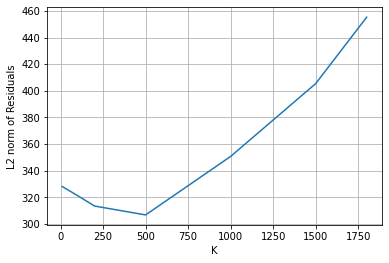

In [ ]:
import matplotlib.pyplot as plt

plt.plot(K, l2_res)
plt.xlabel("K")
plt.ylabel("L2 norm of Residuals")
plt.grid()
plt.show()

### 2. Gaussian Sketching
[On randomized sketching algorithms and the Tracy-Widom law 2.Sketching](https://arxiv.org/pdf/2201.00450v1.pdf)

In [ ]:
def Gaussian_S(frac, structure_rows, m):
  S = csr_matrix((0, m), dtype='float')

  for i, structure in enumerate(myPlan['structures']['Names']):
    structure_voxels = getVoxels(myPlan, structure)
    structure_len = structure_voxels.shape[0]
    new_len = structure_rows[i]
    row_indices = list(range(new_len))
    S = scipy.sparse.vstack((S, scipy.sparse.csr_matrix((np.random.normal(0, 1/np.sum(structure_rows), size=new_len * structure_len),
                                             (row_indices * structure_len, list(structure_voxels-1) * new_len)),
                                              shape=(new_len, m), dtype='float')))
  return S

In [ ]:
def sketch_LS(myPlan, S, voxels):
  l2_res = []
  A = myPlan['infMatrixSparse']
  m, n = A.shape
  d = np.zeros(m)
  gtv = getVoxels(myPlan, 'GTV')
  ptv = getVoxels(myPlan, 'PTV')
  d[gtv - 1] = 2
  d[ptv - 1] = 2
  constraints = []
  x = cp.Variable(n, nonneg=True)
  clinicalConstraints = myPlan['clinicalCriteria']['constraints']
  numFractions = myPlan['clinicalCriteria']['numOfFraction']
  
  A_tilde = S@A
  d_tilde = S@d
  # x_hat = np.linalg.pinv(A_tilde.toarray()).dot(d_tilde)
  # res = A_tilde@x_hat - d
  # l2_res.append(np.linalg.norm(res))
  del S, A, d, ptv, gtv

  for i in range(len(clinicalConstraints)):
    if clinicalConstraints[i]['maxHardConstraint_Gy'] is not None:
      org = clinicalConstraints[i]['structNames']
      if org != 'GTV':
        constraints += [(A_tilde@x)[voxels[org]] <= clinicalConstraints[i]['maxHardConstraint_Gy']/numFractions]
    if clinicalConstraints[i]['meanHardConstraint_Gy'] is not None:
      org = clinicalConstraints[i]['structNames']
      constraints += [(1/len(voxels[org]))*(cp.sum((A_tilde@x)[voxels[org]])) <= clinicalConstraints[i]['meanHardConstraint_Gy']/numFractions]

  obj = cp.Minimize(cp.sum_squares(A_tilde@x - d_tilde))
  prob = cp.Problem(obj, constraints)
  prob.solve(solver=cp.MOSEK, verbose=True)
  return x.value, prob.value, prob

In [ ]:
# Gaussian Sketching

fracs = [500, 600, 700, 800, 900]
res = []

A = myPlan['infMatrixSparse']
m, n = A.shape
d = np.zeros(m)
d[getVoxels(myPlan, 'GTV') - 1] = 2
d[getVoxels(myPlan, 'PTV') - 1] = 2

for frac in fracs:
  print(frac)
  structure_rows = [getVoxels(myPlan, structure).shape[0] // frac for structure in myPlan['structures']['Names']]

  voxels = {}
  new_lens = np.cumsum(structure_rows)
  voxels['GTV'] = np.arange(0, new_lens[0])
  voxels['PTV'] = np.arange(new_lens[0], new_lens[1])
  voxels['ESOPHAGUS'] = np.arange(new_lens[1], new_lens[2])
  voxels['HEART'] = np.arange(new_lens[2], new_lens[3])
  voxels['LUNG_L'] = np.arange(new_lens[3], new_lens[4])
  voxels['LUNG_R'] = np.arange(new_lens[4], new_lens[5])
  voxels['CORD'] = np.arange(new_lens[5], new_lens[6])
  voxels['SKIN'] = np.arange(new_lens[6], new_lens[7])
  voxels['RIND11_PTV_0mm_5mm'] = np.arange(new_lens[7], new_lens[8])
  voxels['RIND12_PTV_5mm_5mm'] = np.arange(new_lens[8], new_lens[9])
  voxels['RIND13_PTV_5mm_20mm'] = np.arange(new_lens[9], new_lens[10])
  voxels['RIND14_PTV_20mm_30mm'] = np.arange(new_lens[10], new_lens[11])
  voxels['RIND15_PTV_30mm_infmm'] = np.arange(new_lens[11], new_lens[12])

  S = Gaussian_S(frac, structure_rows, m)
  value, cost, prob = sketch_LS(myPlan, S, voxels)
  f_x = A@value - d
  res.append((np.sum(structure_rows), f_x))
  del S

500
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 08 04:42:27 PM: Your problem has 2838 variables, 14 constraints, and 0 parameters.
(CVXPY) Nov 08 04:42:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 08 04:42:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 08 04:42:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 08 04:42:27 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 08 04:42:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStu

In [ ]:
prob.solver_stats.solve_time

7.223516941070557

Plot for gaussian sketching

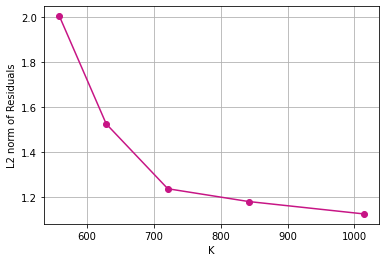

In [ ]:
import matplotlib.pyplot as plt

# fracs = [500, 600, 700, 800, 900]

f_x_star = np.linalg.norm(A@opt_value - d)
g = [(x[0], np.linalg.norm(x[1]) / f_x_star) for x in res]
x = [i[0] for i in g]
y = [i[1] for i in g]

plt.plot(x, y, marker='o', color='mediumvioletred')
plt.xlabel("K")
plt.ylabel("L2 norm of Residuals")
plt.grid()
plt.show()

### 3. Hadamard sketching
[On randomized sketching algorithms and the Tracy-Widom law 2.Sketching](https://arxiv.org/pdf/2201.00450v1.pdf)

In [ ]:
#constructing hadamard matrix

import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import bernoulli
import scipy.linalg as scling
from scipy.sparse import diags
import random

def vstack_to_PhiH(length, selected_rows, PhiH, m, rows, cols):
  H_8192 = scling.hadamard(8192)
  if length < 8192:
    new_mat = scipy.sparse.csr_matrix((scling.hadamard(length)[rows, :cols.shape[0]].flatten(),
                                                               (np.repeat(rows, cols.shape[0]), (cols-1).tolist() * len(rows))),
                                                               shape=(len(rows), m), dtype='float')
    del H_8192, rows, cols, length, selected_rows
    return scipy.sparse.vstack((PhiH, new_mat))
  if length == 8192:
    new_mat = scipy.sparse.csr_matrix((H_8192[rows, :cols.shape[0]].flatten(),
                                                               (np.repeat(rows, cols.shape[0]), (cols-1).tolist() * len(rows))),
                                                               shape=(len(rows), m), dtype='float')
    del H_8192, rows, cols, length, selected_rows
    return scipy.sparse.vstack((PhiH, new_mat))

  H_2 = np.array([[1, 1], [1, -1]])
  factor = int(np.log2(length / 8192))
  factor_H = H_2
  for i in range(factor - 1):
    factor_H = np.kron(H_2, factor_H)
  for index in selected_rows:
    row_block = index // 8192
    row_index = np.remainder(index, 8192)
    H_row = H_8192[row_index, :]
    factor_row = factor_H[row_block, :]
    row = np.kron(factor_row, H_row)
    PhiH = scipy.sparse.vstack((PhiH, scipy.sparse.csr_matrix((row[:len(cols)], ([0] * len(cols), cols-1)), shape=(1, m), dtype='float'))) 
  return PhiH


def Hadamard_S(A, structure_rows, m):
  PhiH = csr_matrix((0, m), dtype='int')
  new_lens = []
  for i, structure in enumerate(myPlan['structures']['Names']):
    number_of_rows = getVoxels(myPlan, structure).shape[0]
    next_power_of_two = 1<<(number_of_rows-1).bit_length()
    new_lens.append(next_power_of_two)
  Phi = [[random.randint(0, new_lens[i]) for j in range(0, structure_rows[i])] for i in range(len(new_lens))]

  for i, structure in enumerate(myPlan['structures']['Names']):
    cols = getVoxels(myPlan, structure)
    rows_len = structure_rows[i]
    rows = list(range(rows_len))
    PhiH = vstack_to_PhiH(new_lens[i], Phi[i], PhiH, m, rows, cols)
    del cols, rows_len, rows

  del new_lens, Phi
  D = diags(tfp.random.rademacher((1, m)).numpy().tolist()[0])
  S = (PhiH @ D)/np.sqrt(np.sum(structure_rows))
  del D
  return S

In [ ]:
# Hadamard Sketching

fracs = [400, 500, 600, 700, 800, 900, 1000]
res = []

A = myPlan['infMatrixSparse']
m, n = A.shape
d = np.zeros(m)
d[getVoxels(myPlan, 'GTV') - 1] = 2
d[getVoxels(myPlan, 'PTV') - 1] = 2

for frac in fracs:
  print(frac)
  structure_rows = [getVoxels(myPlan, structure).shape[0] // frac for structure in myPlan['structures']['Names']]

  voxels = {}
  new_lens = np.cumsum(structure_rows)
  voxels['GTV'] = np.arange(0, new_lens[0])
  voxels['PTV'] = np.arange(new_lens[0], new_lens[1])
  voxels['ESOPHAGUS'] = np.arange(new_lens[1], new_lens[2])
  voxels['HEART'] = np.arange(new_lens[2], new_lens[3])
  voxels['LUNG_L'] = np.arange(new_lens[3], new_lens[4])
  voxels['LUNG_R'] = np.arange(new_lens[4], new_lens[5])
  voxels['CORD'] = np.arange(new_lens[5], new_lens[6])
  voxels['SKIN'] = np.arange(new_lens[6], new_lens[7])
  voxels['RIND11_PTV_0mm_5mm'] = np.arange(new_lens[7], new_lens[8])
  voxels['RIND12_PTV_5mm_5mm'] = np.arange(new_lens[8], new_lens[9])
  voxels['RIND13_PTV_5mm_20mm'] = np.arange(new_lens[9], new_lens[10])
  voxels['RIND14_PTV_20mm_30mm'] = np.arange(new_lens[10], new_lens[11])
  voxels['RIND15_PTV_30mm_infmm'] = np.arange(new_lens[11], new_lens[12])

  S = Hadamard_S(myPlan, structure_rows, m)
  value, cost, prob = sketch_LS(myPlan, S, voxels)
  del S
  res.append((np.sum(structure_rows), A@value - d))
  del value, cost, structure_rows

400
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 08 09:06:15 PM: Your problem has 2838 variables, 14 constraints, and 0 parameters.
(CVXPY) Nov 08 09:06:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 08 09:06:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 08 09:06:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 08 09:06:15 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 08 09:06:15 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStu

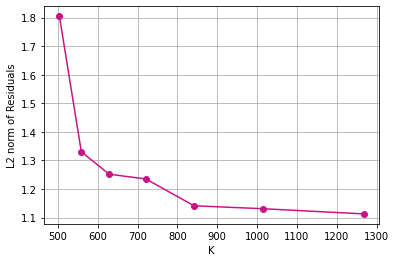

In [ ]:
import matplotlib.pyplot as plt

# fracs = [400, 500, 600, 700, 800, 900, 1000]

f_x_star = np.linalg.norm(A@opt_value - d)
g = [(x[0], np.linalg.norm(x[1]) / f_x_star) for x in res]
x = [i[0] for i in g]
y = [i[1] for i in g]

plt.plot(x, y, marker='o', color='mediumvioletred')
plt.xlabel("K")
plt.ylabel("L2 norm of Residuals")
plt.grid()
plt.show()

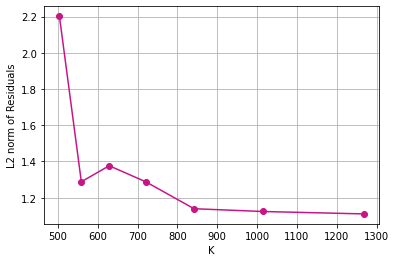

In [ ]:
import matplotlib.pyplot as plt

# fracs = [400, 500, 600, 700, 800, 900, 1000]

f_x_star = 178.77408479493047
g = [(x[0], np.linalg.norm(x[1]) / f_x_star) for x in res]
x = [i[0] for i in g]
y = [i[1] for i in g]

plt.plot(x, y, marker='o', color='mediumvioletred')
plt.xlabel("K")
plt.ylabel("L2 norm of Residuals")
plt.grid()
plt.show()

In [ ]:
prob.solver_stats.solve_time

4.892329216003418

### 4. Clarkson-Woodruff sketching
[On randomized sketching algorithms and the Tracy-Widom law 2.Sketching](https://arxiv.org/pdf/2201.00450v1.pdf)

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import bernoulli
from scipy.sparse import diags
import random

def ClarksonWoodruf_S(new_lens, m):
  Gamma = csr_matrix((0, m), dtype='float')
  for i, structure in enumerate(myPlan['structures']['Names']):
    cols = getVoxels(myPlan, structure)
    cols_len = cols.shape[0]
    rows_len = new_lens[i]
    rows = list(range(rows_len))
    Gamma = scipy.sparse.vstack((Gamma, scipy.sparse.csr_matrix(([1] * cols_len,
                                             (np.random.uniform(low=0, high=rows_len, size=cols_len), cols-1)),
                                              shape=(rows_len, m), dtype='float'))) 
  D = diags(tfp.random.rademacher((1, m)).numpy().tolist()[0])
  S = Gamma@D
  return S

In [ ]:
# Clarkson-Woodruf sketching
import random

fracs = [10, 50, 100, 200, 300, 500, 700, 900]
res = []

A = myPlan['infMatrixSparse']
m, n = A.shape
d = np.zeros(m)
d[getVoxels(myPlan, 'GTV') - 1] = 2
d[getVoxels(myPlan, 'PTV') - 1] = 2

for frac in fracs:
  print(frac)
  structure_rows = [getVoxels(myPlan, structure).shape[0] // frac for structure in myPlan['structures']['Names']]

  voxels = {}
  new_lens = np.cumsum(structure_rows)
  voxels['GTV'] = np.arange(0, new_lens[0])
  voxels['PTV'] = np.arange(new_lens[0], new_lens[1])
  voxels['ESOPHAGUS'] = np.arange(new_lens[1], new_lens[2])
  voxels['HEART'] = np.arange(new_lens[2], new_lens[3])
  voxels['LUNG_L'] = np.arange(new_lens[3], new_lens[4])
  voxels['LUNG_R'] = np.arange(new_lens[4], new_lens[5])
  voxels['CORD'] = np.arange(new_lens[5], new_lens[6])
  voxels['SKIN'] = np.arange(new_lens[6], new_lens[7])
  voxels['RIND11_PTV_0mm_5mm'] = np.arange(new_lens[7], new_lens[8])
  voxels['RIND12_PTV_5mm_5mm'] = np.arange(new_lens[8], new_lens[9])
  voxels['RIND13_PTV_5mm_20mm'] = np.arange(new_lens[9], new_lens[10])
  voxels['RIND14_PTV_20mm_30mm'] = np.arange(new_lens[10], new_lens[11])
  voxels['RIND15_PTV_30mm_infmm'] = np.arange(new_lens[11], new_lens[12])

  S = ClarksonWoodruf_S(structure_rows, m)
  value, cost, prob = sketch_LS(myPlan, S, voxels)
  f_x = A@value - d
  res.append((np.sum(structure_rows), f_x))
  del S, value, cost, f_x

10
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 08 09:55:49 PM: Your problem has 2838 variables, 14 constraints, and 0 parameters.
(CVXPY) Nov 08 09:55:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 08 09:55:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 08 09:55:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 08 09:55:49 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 08 09:55:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuf

SolverError: ignored

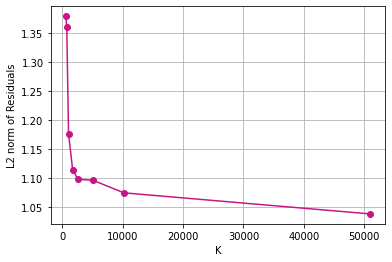

In [ ]:
import matplotlib.pyplot as plt

# fracs = [10, 50, 100, 200, 300, 500, 700, 900]

f_x_star = np.linalg.norm(A@opt_value - d)
g = [(x[0], np.linalg.norm(x[1]) / f_x_star) for x in res]
x = [i[0] for i in g]
y = [i[1] for i in g]

plt.plot(x, y, marker='o', color='mediumvioletred')
plt.xlabel("K")
plt.ylabel("L2 norm of Residuals")
plt.grid()
plt.show()